# Preprocessing, Modeling

In [1]:
# Importing our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
import datetime as dt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (roc_auc_score, confusion_matrix, recall_score, precision_score, 
                             roc_curve, f1_score, plot_confusion_matrix)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance
import shap

C:\Users\thien\individual\anaconda3\envs\dsi-sg\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Ensuring notebook remains tidy
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting our seaborn style and palette
sns.set_style('darkgrid')
sns.set_palette('icefire')

In [4]:
# Creating a custom function to kick-start the EDA process
def eda_clean(df):
    print('Dataset Statistics:')
    print(f'Shape of dataframe: {df.shape}')
    print('--------------------------------------')
    print(f'Null values in dataframe: {df.isna().sum().sum()}')
    print('--------------------------------------')
    print(f'% of Null values in dataframe: {round(((df.isna().sum().sum())/(df.shape[0])) * 100, 2)}%')
    print('--------------------------------------')
    print(f"Total duplicate rows: {df[df.duplicated()].shape[0]}")
    print('--------------------------------------')
    print(f"% duplicate rows: {round(df[df.duplicated()].shape[0] / df.shape[0] * 100, 2)}%")
    print(f'\nColumn names: {df.columns}')
    print('\nVariable Types')
    print(f"Columns Count: \n{df.dtypes.value_counts()}")

In [5]:
# Import our tidied train dataset
train_transformed = pd.read_csv('../assets/cleaned/train_tidied.csv')

In [6]:
# Dropping redundant columns
train_transformed.drop(columns=['date', 'addressnumberandstreet', 'year_month', 'station', 'station_ref', 'year'], inplace=True)

In [7]:
# Dropping null and nan columns
train_transformed.dropna(inplace=True)

In [8]:
# A quick snapshot of our final dataframe
train_transformed.head()

,wnvpresent,month,week,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,...,TERRITANS,TARSALIS,ERRATICUS,tavg,preciptotal,sealevel,resultspeed,resultdir,humidity,trange
0,0,5,22,0,0,0,1,0,0,0,...,0,0,0,77.0,0.0,30.09,5.8,16.0,53.799129,23.0
1,0,5,22,0,0,0,1,0,0,0,...,0,0,0,77.0,0.0,30.09,5.8,16.0,53.799129,23.0
2,0,5,22,0,0,0,1,0,0,0,...,0,0,0,77.0,0.0,30.09,5.8,16.0,53.799129,23.0
3,0,5,22,0,0,0,0,1,0,0,...,0,0,0,77.0,0.0,30.09,5.8,16.0,53.799129,23.0
4,0,5,22,0,0,0,0,0,0,1,...,0,0,0,77.0,0.0,30.09,5.8,16.0,53.799129,23.0


In [9]:
# Defining X and y variables for our train split
X = train_transformed.drop(columns='wnvpresent')
y = train_transformed['wnvpresent']

In [10]:
# Do a train-test split of 70-30 for train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    stratify=y, # Because this is an unbalanced dataset
                                                    random_state=42)

**Polynomial Features**

We have accounted for the interactions between different features. Model results were not very different.

In [11]:
# # generates the full polynomial feature table
# pf = PolynomialFeatures(include_bias=False, degree=2)
# X_train_pf = pf.fit_transform(X_train)

# # Adds appropriate feature names to all polynomial features
# X_train_pf = pd.DataFrame(X_train_pf, columns=pf.get_feature_names(X_train.columns))

**Solving the problem with an unbalanced dataset** 

In classification problems, balancing your data is absolutely crucial. Data is said to be imbalanced when instances of one class outnumber the other(s) by a large proportion. One of the sampling techniques that we have decided to employ is **SMOTE** (Synthetic Minority Over-Sampling Technique).

Just like the name suggests, the technique generates synthetic data for the minority class. SMOTE proceeds by joining the points of the minority class with line segments and then places artificial points on these lines. Here's how it works:

* Choose a minority class input vector
* Find its k nearest neighbors (k_neighbors is specified as an argument in the SMOTE() function)
* Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor
* Repeat the steps until data is balanced

In [12]:
# create function to run model with standard scaling, SMOTE sampling, 
# with an option to run grid search, model and print results

def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=5, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
    else:
        pipe.fit(X_train, y_train)
        

    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    auc_scores = cross_val_score(pipe, X_train, y_train,  scoring='roc_auc', cv = 5)

    results['model'] = mod
    
    results['train_auc_cv'] = auc_scores.mean()
    
    results['f1'] = f1_score(y_test, predictions)
    results['recall'] = recall_score(y_test, predictions)        # % OF ACTUAL positives that are CORRECTLY predicted
    results['precision'] = precision_score(y_test, predictions)  # % OF positives that are CORRECTLY predicted

    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['auc_diff'] = results['train_auc'] - results['test_auc']

    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)

    return pipe

In [13]:
%%time

X_train_copy = X_train.astype(float).copy()
y_train_copy = y_train.astype(float).copy()

# create loop to run SMOTE sampling and compare the modelling outcomes with and without it
for k in ['No', 'SMOTE']:
    print('\nMethod Used: {}'.format(k + ' sampling'), "-" * 100)
        
    print('\nClass Balance BEFORE')
    display(y_train.value_counts(normalize=True))
    print('Number of rows: {}'.format(y_train.shape[0]))
  
    # instiantiate the models
    methods = {'SMOTE': SMOTE(random_state=42)}
    
    if k == 'SMOTE':
        mthd = methods[k]
        X_train, y_train = mthd.fit_resample(X_train, y_train)

    print('\nClass Balance AFTER')
    display(y_train.value_counts(normalize=True))
    print('Number of rows: {}'.format(y_train.shape[0]),'\n')
    
    
    # Instiantiate models
    models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
              'rf': RandomForestClassifier(random_state=42),
              'gb': GradientBoostingClassifier(random_state=42),
              'dt': DecisionTreeClassifier(random_state=42),
              'et': ExtraTreesClassifier(random_state=42),
              'ada': AdaBoostClassifier(random_state=42),
              'svc': SVC(random_state=42, probability=True),
              'xgb': XGBClassifier(random_state=42, 
                              objective='binary:logistic', 
                              verbosity=1, n_jobs=-1)
            }

    # Instantiate lists to store results
    init_list = []
    gs_list = []

    for m in models:
        run_model(m)
    result_df = pd.DataFrame(init_list).sort_values(by=["f1"], ascending=False).reset_index(drop=True)
    display(result_df)

    X_train = X_train_copy
    y_train = y_train_copy


Method Used: No sampling ----------------------------------------------------------------------------------------------------

Class Balance BEFORE


0    0.9459
1    0.0541
Name: wnvpresent, dtype: float64

Number of rows: 5915

Class Balance AFTER


0    0.9459
1    0.0541
Name: wnvpresent, dtype: float64

Number of rows: 5915 

[00:12:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:12:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:12:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:12:58] WARNING: C:/Users/Administrator/work

,model,train_auc_cv,f1,recall,precision,train_auc,test_auc,auc_diff
0,dt,0.588817,0.226087,0.189781,0.279570,0.998899,0.590944,0.407954
1,xgb,0.839769,0.189349,0.116788,0.500000,0.969301,0.839621,0.129679
2,rf,0.797279,0.114286,0.072993,0.263158,0.998893,0.813458,0.185435
3,ada,0.821210,0.094595,0.051095,0.636364,0.873107,0.814012,0.059096
4,et,0.735728,0.071429,0.043796,0.193548,0.998899,0.757477,0.241422
5,gb,0.832792,0.055172,0.029197,0.500000,0.909630,0.829515,0.080114
6,lr,0.759705,0.000000,0.000000,0.000000,0.815812,0.744606,0.071206
7,svc,0.742393,0.000000,0.000000,0.000000,0.962577,0.736132,0.226444



Method Used: SMOTE sampling ----------------------------------------------------------------------------------------------------

Class Balance BEFORE


0.0    0.9459
1.0    0.0541
Name: wnvpresent, dtype: float64

Number of rows: 5915

Class Balance AFTER


0.0    0.5
1.0    0.5
Name: wnvpresent, dtype: float64

Number of rows: 11190 

[00:14:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:14:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:14:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:14:54] WARNING: C:/Users/Administrator/wor

,model,train_auc_cv,f1,recall,precision,train_auc,test_auc,auc_diff
0,gb,0.981377,0.259325,0.532847,0.171362,0.984308,0.811407,0.172901
1,ada,0.956999,0.247295,0.583942,0.156863,0.962027,0.792044,0.169983
2,svc,0.985742,0.240000,0.240876,0.239130,0.990637,0.772569,0.218067
3,xgb,0.993365,0.215385,0.153285,0.362069,0.998337,0.842460,0.155877
4,et,0.988891,0.193237,0.145985,0.285714,0.999937,0.768803,0.231134
5,lr,0.821400,0.180498,0.635036,0.105200,0.827560,0.739145,0.088416
6,rf,0.997200,0.172589,0.124088,0.283333,0.999936,0.815901,0.184035
7,dt,0.955336,0.153846,0.138686,0.172727,0.999937,0.567881,0.432056


Wall time: 2min 39s


## Selection of our final model (XGBoost)

Due to the unbalanced nature of this dataset, the main metric on our radar is the ROC AUC. **XGBoost** fares scores pretty well on the validation set and requires less computational input compared to **ADABoost**.

We will create a pipeline and tune some hyperparameters below.

In [14]:
# Creating a pipeline model for StandardScaler, SMOTE and XGBoost
xgb_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('xgb', XGBClassifier(random_state=42, 
                              objective= 'binary:logistic', 
                              verbosity=1, n_jobs=-1))
    ])
# Parameters
xgb_params = {  'xgb__learning_rate': [0.1],
                'xgb__max_depth': [40],
                'xgb__min_child_weight': [25],
                'xgb__gamma': [0.85],
                'xgb__subsample': [1],
                'xgb__scale_pos_weight': [63],
                'xgb__n_estimators': [49]}

In [15]:
%%time

xgb_best = run_model('xgb', xgb_params, grid_search=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[00:15:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[00:15:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[00:15:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' wa

{'xgb__gamma': 0.85,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 40,
 'xgb__min_child_weight': 25,
 'xgb__n_estimators': 49,
 'xgb__scale_pos_weight': 63,
 'xgb__subsample': 1}

Wall time: 17.8 s


In [16]:
# create table to show the predictors with the highest importance (i.e. strongest predictors of the presence of WNV)
feature_names = X.columns
coefficients = pd.DataFrame(np.squeeze(xgb_best.best_estimator_.named_steps["xgb"].feature_importances_),
                            columns=['Importances']) 
features = pd.DataFrame(np.squeeze(feature_names), columns=['Features']) 
df = pd.concat([features, coefficients], axis='columns').sort_values('Importances', ascending=False)

In [17]:
df.head(15)

,Features,Importances
1,week,0.130479
0,month,0.053143
33,cluster_31,0.033728
80,PIPIENS,0.031945
6,cluster_4,0.031897
25,cluster_23,0.031414
35,cluster_33,0.030620
62,cluster_60,0.025945
87,sealevel,0.025865
75,cluster_73,0.025526


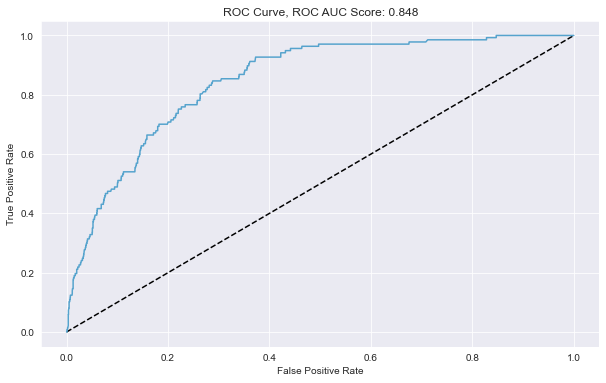

In [18]:
y_pred_prob = xgb_best.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, ROC AUC Score: {}'.format(roc_auc_score(y_test, y_pred_prob).round(3)))
plt.show()

## Tidying ```test``` data

We will need to import our test data and carry out the pre-requisite pre-processing steps. We have created custom functions for this bit of the codebook.
* Initial cleaning (Dropping address, block, street, addressaccuracy columns)
* Date feature engineering (Extracting year, month, week, day variables)
* Dummify our ```cluster``` column
* One-hot encoding mosquito species
* Determining if a coordinate is closer to Station 1 or Station 2
* Final cleaning (Dropping the remaining unnecessary columns)
* Generating predictions from our best model

After applying each function, we will map it to a new variable to ensure the process flows smoothly.

In [19]:
# Read train and test datasets
test = pd.read_csv('../assets/cleaned/test_tidied.csv', parse_dates=['date'])

# Converting columns to lowercase for standardisation
test.columns = test.columns.str.lower()

In [20]:
# Previewing our test dataset
eda_clean(test)

Dataset Statistics:
Shape of dataframe: (116293, 13)
--------------------------------------
Null values in dataframe: 0
--------------------------------------
% of Null values in dataframe: 0.0%
--------------------------------------
Total duplicate rows: 0
--------------------------------------
% duplicate rows: 0.0%

Column names: Index(['id', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'coord', 'cluster'],
      dtype='object')

Variable Types
Columns Count: 
object            6
int64             4
float64           2
datetime64[ns]    1
dtype: int64


In [21]:
def initial_clean(df):
    df.drop(columns=['address', 'block', 'street', 'addressaccuracy'], inplace=True)
    return df

In [22]:
test_iter1 = initial_clean(test)

In [23]:
def date_feature_engineering(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.isocalendar().week
    df['day'] = df['date'].dt.day
    df['year_month'] = df['date'].dt.strftime("%Y-%m")

    return df

In [24]:
test_iter2 = date_feature_engineering(test_iter1)

In [25]:
test_iter3 = pd.get_dummies(test_iter2, columns=['cluster'])

In [26]:
# We can exclude Unsepcified species from this selection
species_of_interest = ['RESTUANS', 'PIPIENS', 
                       'SALINARIUS', 'TERRITANS', 'TARSALIS', 'ERRATICUS'
                      ]

# create loop to create dummified variables to indicate presence of Pipiens & Restuans species
def dummify_species(df):
    for i in species_of_interest:
        df[i] = df['species'].apply(lambda x: 1 if i in x else 0)
    
    return df

In [27]:
test_iter4 = dummify_species(test_iter3)

In [28]:
def determine_station(lat, long):
    station1 = (41.995, -87.933) #Chicago O'Hare Tntl Airpot -> lat: 41.995 long: -87.933
    station2 = (41.786, -87.752) #Chicago Midway Tntl Airpot -> lat: 41.786 long: -87.752
    coordinates = (lat, long)
    
    return 1 if geodesic(coordinates, station1) < geodesic(coordinates, station2) else 2

In [29]:
%%time

# Apply function to map our function
test_iter4['station_ref'] = test_iter4.apply(lambda i: determine_station(i['latitude'], i['longitude']), axis=1)

Wall time: 37 s


In [30]:
# Import tidied weather dataset
weather_tidied = pd.read_csv('../assets/cleaned/weather_tidied.csv', parse_dates=['date'])

In [31]:
test_iter5 = test_iter4.merge(weather_tidied, how='left', left_on=['station_ref', 'date'], right_on=['station', 'date'])
test_iter5.drop(columns=["station"], inplace=True)

In [32]:
def final_clean(df):
    df.drop(columns=['species', 'trap', 'date', 'addressnumberandstreet', 
                     'latitude', 'longitude', 
                     'day', 'coord',
                     'year_month', 'station_ref', 'year'], inplace=True)
    
    return df

In [33]:
test_iter6 = final_clean(test_iter5)

In [34]:
def predict_best(df, model_best):
    df_id = df['id']

    df_base = df.drop(columns=['id'])
    
    # generate predictions
    y_pred = model_best.best_estimator_.predict(df_base)  

    # load prediction into dataframe
    df_pred = pd.DataFrame(y_pred, columns=['wnvpresent']) 

    # Merge id with predictions into one dataframe
    df_final = pd.concat([df_id, df_pred], axis='columns')
    return df_final

def predict_proba_best(df, model_best):
    df_coord = test[['latitude', 'longitude']]
    
    df_base = df.drop(columns=['id'])
    
    # generate predictions
    y_pred = model_best.best_estimator_.predict_proba(df_base)  

    # load prediction into dataframe
    df_pred = pd.DataFrame(np.squeeze(y_pred)) 

    # Merge id with predictions into one dataframe
    df_final = pd.concat([df_coord, df_pred], axis='columns')
    return df_final

In [35]:
# generate predictions
pred = predict_best(test_iter6, xgb_best)

In [36]:
pred.rename(columns={'id': 'Id', 'wnvpresent':'WnvPresent'}, inplace=True)

In [37]:
pred = pred.set_index('Id')

In [38]:
pred.to_csv('../kaggle/submission.csv')

In [39]:
test.to_csv('../assets/test_final.csv')

**Kaggle Submission Score**

**Thoughts**: We believe further improvements can be made to the model (if given enough time). Here are some of our considerations:
* There could be a bias for certain traps (Given that a particular trap may always capture more mosquitos, etc)
* Possibility of a daily multiplier given an array of outbreaks; Outbreaks will possibly influence the days before and after it (They tend to cluster in the dimension of time too)

![Our Kaggle submission](../images/kaggle_submission.png "Our Kaggle submission")

#### SHAP for Model Interpretation

In [40]:
shap.initjs()

In [41]:
model = xgb_best.best_estimator_

In [42]:
model

Pipeline(steps=[('ss', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0.85, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=40,
                               min_child_weight=25, missing=nan,
                               monotone_constraints='()', n_estimators=49,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=63, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=1))])

In [43]:
model[1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.85, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=40, min_child_weight=25, missing=nan,
              monotone_constraints='()', n_estimators=49, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=63, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [44]:
explainer = shap.TreeExplainer(model[1])

In [45]:
shap_values = explainer(X_test)

#### Interpret Model Globally

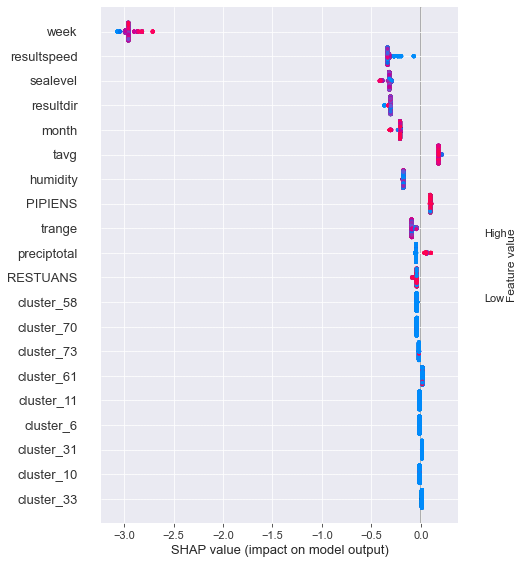

In [46]:
shap.summary_plot(shap_values, X_test)

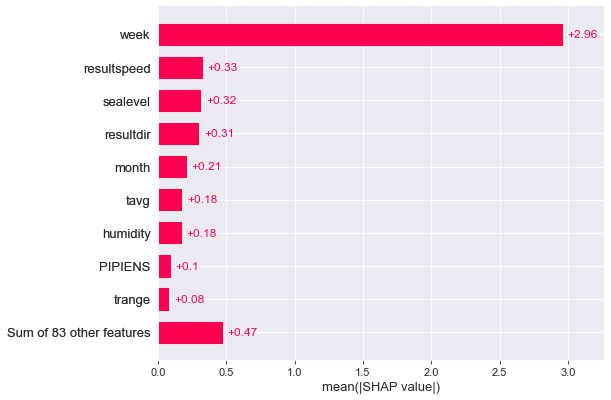

In [47]:
shap.plots.bar(shap_values)

#### Interpret Model Locally - First 5 rows of X_test

In [48]:
shap.plots.force(shap_values[0])

![shap0](../images/shap3.png "SHAP")

In [49]:
shap.plots.force(shap_values[1])

![shap0](../images/shap4.png "SHAP")

In [50]:
shap.plots.force(shap_values[2])

![shap0](../images/shap5.png "SHAP")

In [51]:
shap.plots.force(shap_values[3])

![shap0](../images/shap6.png "SHAP")

In [52]:
shap.plots.force(shap_values[4])

![shap0](../images/shap7.png "SHAP")